# Data pre-processing

Pre-processing of data from notebook [Data Process](./dataProcess.ipynb)

In [1]:
%%capture

import sys
!{sys.executable} -m pip install nbformat

%run -G ./dataProcess.ipynb

## First Model Building and Evaluation

We are going to train a Logistic Regression Model to as a first approach to the model selection. 

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
logisticRegr = LogisticRegression(max_iter=1000)
logisticRegr.fit(X_train, y_train)

train_predictions = logisticRegr.predict(X_train)
test_predictions = logisticRegr.predict(X_test)

### Train results

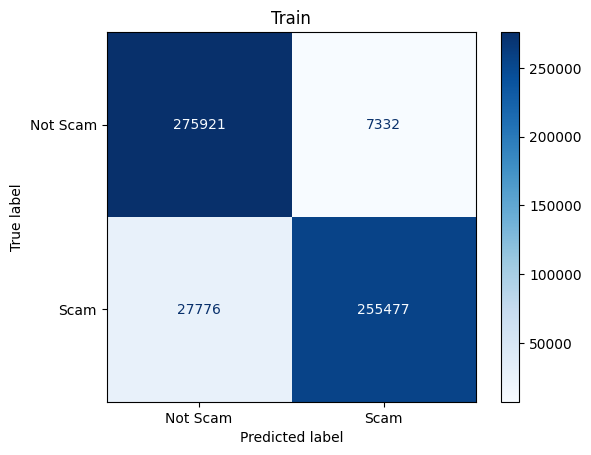

              precision    recall  f1-score   support

           0       0.91      0.97      0.94    283253
           1       0.97      0.90      0.94    283253

    accuracy                           0.94    566506
   macro avg       0.94      0.94      0.94    566506
weighted avg       0.94      0.94      0.94    566506



In [4]:
cm = confusion_matrix(y_train, train_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Scam', 'Scam'])
disp.plot(cmap='Blues')
plt.title('Train')
plt.show() 

cr = classification_report(y_train,train_predictions)
print(cr)

### Test results

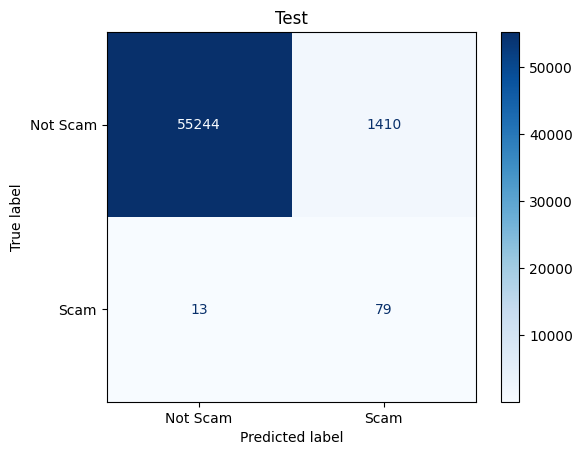

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56654
           1       0.05      0.86      0.10        92

    accuracy                           0.97     56746
   macro avg       0.53      0.92      0.54     56746
weighted avg       1.00      0.97      0.99     56746



In [5]:
cm = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Scam', 'Scam'])
disp.plot(cmap='Blues')
plt.title('Test')
plt.show() 

cr = classification_report(y_test,test_predictions)
print(cr)